# Shear profile fitting

This CLMassmod notebook examplifies how to go from simulation outputs to shear profile fitting and cluster mass reconstruction.

The test simulated cluster comes the MXXL simulation. 

In [3]:
#  python setup.py develop <--- useful for if you're developing and changing code
import matplotlib.pyplot as plt 
%matplotlib inline
import sys
sys.path.append("readers/")
import readMXXL as rm

## Load in MXXL data with the specified reader and have first look at data

This will read in 
- convergence kappa map
- shear maps (gamma1, gamma2)
 


In [4]:
simreader = rm.MXXLSimReader()
path_to_mxxl = '/Users/combet/RECHERCHE/LSST/data_clmassmod/mxxl/halo_54_100_0'
loaded_catalog = simreader.load(path_to_mxxl)

Loading /Users/combet/RECHERCHE/LSST/data_clmassmod/mxxl/halo_54_100_0


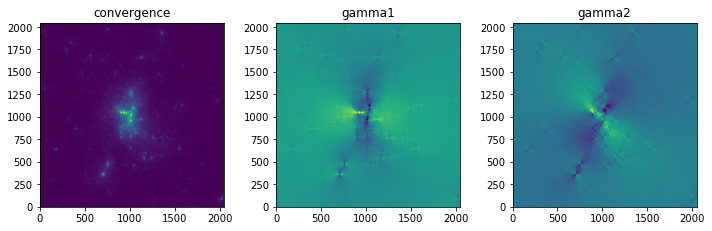

In [5]:
import numpy as np
reshape_size=int(np.sqrt(loaded_catalog.gamma1_inf.size))
gamma1_inf = loaded_catalog.gamma1_inf.reshape((reshape_size,reshape_size))
gamma2_inf = loaded_catalog.gamma2_inf.reshape((reshape_size,reshape_size))
kappa_inf = loaded_catalog.kappa_inf.reshape((reshape_size,reshape_size))

f, axes = plt.subplots(1, 3, figsize=(10,10))
axes[0].pcolormesh(kappa_inf)
axes[0].set_title('convergence')
axes[1].pcolormesh(gamma1_inf)
axes[1].set_title('gamma1')
axes[2].pcolormesh(gamma2_inf)
axes[2].set_title('gamma2')
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')
axes[2].set_aspect('equal')
f.tight_layout()
plt.show()

## Build radial reduced shear profile from the simulation according to a given configuration 

- Configuration is given in `sampleconfig.py`. In particular, this specifies which `simreader` to use to read the simulation data. 
- Some miscentering is randomly introduced prior to building the profile. Using `np.random.seed(0)` ensures repeatability.
- The shear radial profile is stored in `profile_of_sims_from_config`. 

In [7]:
import simutils
config = simutils.readConfiguration('sampleconfig.py')

In [8]:
# Load the simreader specified in the config
simreader_from_configfile = config['simreader']
loaded_sim_from_config = simreader_from_configfile.load(path_to_mxxl)

# Build the profile with builder specified from config
np.random.seed(0)
profilebuilder_from_config = config['profilebuilder']
profile_of_sim_from_config = profilebuilder_from_config(loaded_sim_from_config)

Loading /Users/combet/RECHERCHE/LSST/data_clmassmod/mxxl/halo_54_100_0
Center Offset: 0.00973387182736 0.00264849667343


In [9]:
# These are the available fields
print profile_of_sim_from_config.table.keys()

['sigma_ghat', 'beta_s', 'ngals', 'r_mpc', 'ghat', 'beta_s2']


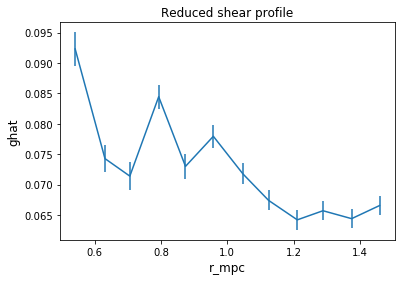

In [10]:
profile_of_sim_from_config.table['r_mpc'] #center of radial bins
plt.errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
                yerr=profile_of_sim_from_config.table['sigma_ghat'])
plt.title('Reduced shear profile')
plt.xlabel('r_mpc',fontsize='large')
plt.ylabel('ghat',fontsize='large')
plt.show()

## Let's fit the above reduced shear profile

- First define the model to be fitted to the data - `model_reduced_shear`
- Two free parameters are the mass and concentration of the cluster
- As first test, simply use `scipy.optimize.curve_fit` to fit 

In [11]:
def model_reduced_shear( const_args, mass15, cdelta ) :
    from nfwmodeltools import NFWKappa, NFWShear
    import numpy as np
    
    mass = mass15 * 1e15
    (r, avg_beta, avg_beta2, rho_c, rho_c_over_sigma_c, delta) = const_args
    
    rdelta =(3*abs(mass)/(4*delta*np.pi*rho_c))**(1./3.)
    rscale = rdelta / cdelta
    kappa_inf = NFWKappa(r, cdelta, rscale, rho_c_over_sigma_c, delta = delta)
    gamma_inf = NFWShear(r, cdelta, rscale, rho_c_over_sigma_c, delta = delta)
    
    return avg_beta * gamma_inf / (1 - kappa_inf * avg_beta2/avg_beta)

In [12]:
avg_beta = profile_of_sim_from_config.table['beta_s']
avg_beta2 = profile_of_sim_from_config.table['beta_s2']
zcluster = profile_of_sim_from_config.zcluster

from nfwutils import global_cosmology
rho_c = global_cosmology.rho_crit(zcluster)
# note: global_cosmology.beta([1e6], zcluster) is beta at effectively infinite redshift
rho_c_over_sigma_c = 1.5 * global_cosmology.angulardist(zcluster) * \
    global_cosmology.beta([1e6], zcluster)[0] * global_cosmology.hubble2(zcluster) / \
            global_cosmology.v_c**2
delta=200

x_data = (profile_of_sim_from_config.table['r_mpc'], 
          avg_beta, avg_beta2, rho_c, rho_c_over_sigma_c, delta)
y_data = profile_of_sim_from_config.table['ghat']
sigma = profile_of_sim_from_config.table['sigma_ghat']
print x_data

(array([ 0.54129303,  0.63111535,  0.70603529,  0.7930565 ,  0.87384366,
        0.95778531,  1.04713125,  1.12434209,  1.21080741,  1.28826094,
        1.37463714,  1.45872873]), array([ 0.38262839,  0.38262839,  0.38262839,  0.38262839,  0.38262839,
        0.38262839,  0.38262839,  0.38262839,  0.38262839,  0.38262839,
        0.38262839,  0.38262839]), array([ 0.14640448,  0.14640448,  0.14640448,  0.14640448,  0.14640448,
        0.14640448,  0.14640448,  0.14640448,  0.14640448,  0.14640448,
        0.14640448,  0.14640448]), 173483877965.92105, 7.6540848512401328e-05, 200)


In [80]:
# Let's fit
from scipy.optimize import curve_fit
popt, pcov = curve_fit(model_reduced_shear, x_data, y_data, sigma=sigma)

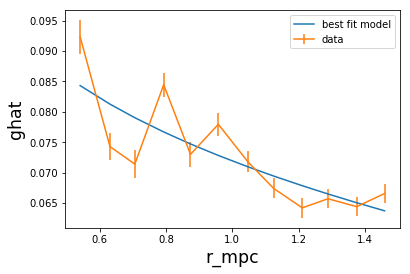

In [19]:
plt.plot(profile_of_sim_from_config.table['r_mpc'], model_reduced_shear( x_data, *popt ), label = 'best fit model')
plt.errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
            yerr=profile_of_sim_from_config.table['sigma_ghat'], label='data')
plt.xlabel('r_mpc',fontsize='xx-large')
plt.ylabel('ghat',fontsize='xx-large')
plt.legend()

In [102]:
#print popt, pcov
print "From curve_fit:"
print "Best fit mass = ", popt[0]*1.e15,"Msun"
print "Best fit concentration = ", popt[1]

From curve_fit:
Best fit mass =  2.1572934163e+16 Msun
Best fit concentration =  1.36439877108


## Now, let's move to the Bayesian approach, using pymc to sample the posterior of the parameters

In [105]:
# Let's create a directed acyclic graph: Baysian Network to do the analog to curve_fit
# with pymc, taking into account prior distributions.
import pymc
mass15 = pymc.Uniform('mass15',0.01, 150)
concentration = pymc.Uniform('concentration',1., 15.)

@pymc.deterministic(trace=False)  # Applies to gmodel in the next line
def gmodel(x_data=x_data, mass15=mass15, concentration=concentration) :
    return model_reduced_shear(x_data, mass15, concentration)

gsigma = sigma  # This *could* be a probability distribution
tau = 1./gsigma**2
#@pymc.observed <---- this is needed if the next line is a function 
# that calculates likelihood and returns the log probability
gobserved = pymc.Normal('gobserved', mu=gmodel, tau=tau, value=y_data, observed=True)

In [26]:
# Let's create a pymc model object from the nodes of the graph
pymc_model = pymc.Model([mass15, concentration, gmodel, gobserved])

In [27]:
# Print initial values
print mass15.value, concentration.value

79.8221476079 6.19975625183


In [28]:
# Print log probability of the Bayesian network
print pymc_model.logp

-2889465.4255


In [29]:
# We can manually change the values and see how the log prob changes (e.g. more reasonable mass, and larger logp) 
mass15.value = 1.
print pymc_model.logp

-3381.29626573


In [30]:
# We can find parameters that maximize log prob of the network
pymc_maximum_aposteriori = pymc.MAP(pymc_model)
pymc_maximum_aposteriori.fit()
print mass15.value, concentration.value
print gmodel.value

21.5710122451 1.36449542092
[ 0.08430545  0.08126153  0.07902679  0.07669018  0.07471627  0.07282472
  0.07095795  0.06944705  0.06785133  0.0664974   0.0650616   0.06373073]


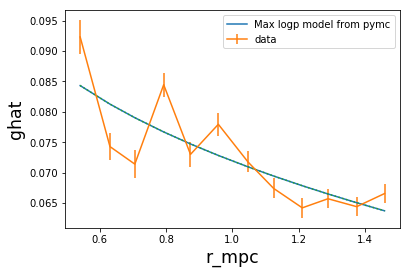

In [33]:
# Let's compare with the data

plt.plot(profile_of_sim_from_config.table['r_mpc'], model_reduced_shear(x_data, mass15.value, concentration.value),
         label='Max logp model from pymc')
plt.errorbar(profile_of_sim_from_config.table['r_mpc'], profile_of_sim_from_config.table['ghat'], 
            yerr=profile_of_sim_from_config.table['sigma_ghat'], label='data')
plt.plot(profile_of_sim_from_config.table['r_mpc'], gmodel.value, ls=":")
plt.xlabel('r_mpc',fontsize='xx-large')
plt.ylabel('ghat',fontsize='xx-large')
plt.legend()

In [34]:
#  Let's now explore the full posterior without making any normal approximations, etc.
pymc_MCMC = pymc.MCMC(pymc_model)
# Let's run for 1000 iterations
pymc_MCMC.sample(1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.1 sec

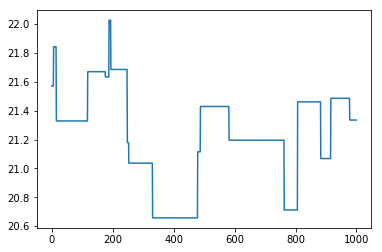

In [36]:
# We want to plot a value vs. steps in chain.  Note -this has not yet converged
plt.plot(pymc_MCMC.trace('mass15')[:])

In [42]:
# Let's run for longer now
pymc_MCMC.sample(300000)


 [-----------------100%-----------------] 300000 of 300000 complete in 39.9 sec

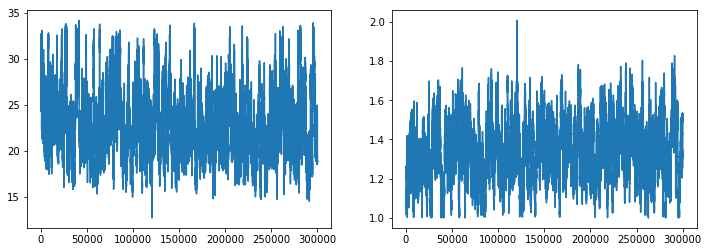

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(pymc_MCMC.trace('mass15')[:])
axes[1].plot(pymc_MCMC.trace('concentration')[:])


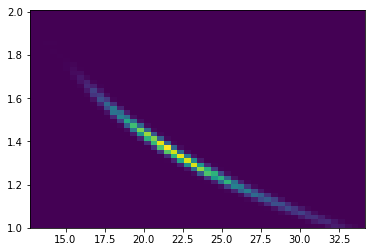

In [98]:
#  We are now plotting P(M, c | ghat )
hist = plt.hist2d(pymc_MCMC.trace('mass15')[:], pymc_MCMC.trace('concentration')[:], bins=50)

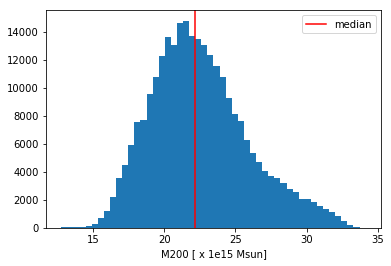

In [100]:
hist = plt.hist(pymc_MCMC.trace('mass15')[30000:], bins=50)
plt.axvline(np.median(pymc_MCMC.trace('mass15')[30000:]), c='r', label='median')
plt.xlabel('M200 [ x 1e15 Msun]')
plt.legend()

In [94]:
print "Median mass from posterior = ",np.median(mass15.trace())*1.e15,"Msun" 

Median mass from posterior =  2.22666978073e+16 Msun


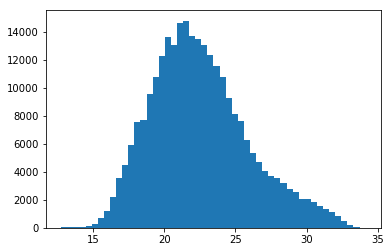

In [97]:
hist = plt.hist(mass15.trace()[30000:], bins=50)